#  Geolocation

- formulation of a solver.

- statistical simulations in order to determine sources of uncertainty

---

# 1 - Formulation

<img src='schematic.jpeg' alt='Drawing' align='right' style='width: 300px;'/>

We want to find the float horizontal position $\underline{x}$ of an underwater float 
given a number of **known variables**:
- $\underline{x}_s^i$ : source surface float horizontal position
- $t_e^i$ : time of emission for source $i$
- $\tilde{t}_r^i$ : time of reception of the signal emitted by source $i$ by the underwater float
- $\epsilon_i$ : signal detection, $\epsilon_i=1$ (detection) or $1$ (no detection)
- $z$ : underwater float depth(perfect knowledge), not used for now

'Perfect' knowledge is assumed for known variables wich amounts to say potential errors on there
estimates may be neglected.

---
**Unknown variables** are:
- $\underline{x}$ : underwater float position
- $\delta t$ : underwater float clock offset, $\delta t = \tilde{t}_r^i - t_r^i$, where 
$t_r^i$ is the true time of reception
- $\delta \underline{x}^i$ : vector difference between source $i$ transducer position and surface float position, $\delta \underline{x}^i = \underline{x}_t^i - \underline{x}_s^i$
- $\delta t_p (\underline{x},\underline{x}_t^i)$ : difference between actual $(t_r^i - t_e^i)$ and an priori time $t_p(\underline{x},\underline{x}_t^i)$ of propagation between $\underline{x}$ and $\underline{x}_t^i$.

For simplicity, we assume the assumed propagation time is a function of range only: $t_p(\underline{x},\underline{x}_t^i) = t_p(|| \underline{x} - \underline{x}_t^i ||)$.

$t_p$ may for example be given by an a priori estimate of velocity ($c_b$) along with a measure of velocity uncertainty ($e_c$). In this case, we expect the error on time to grow with range according to: $e_{tp} \propto || \underline{x}_b - \underline{x}_t^i || /e_c$, where $\underline{x}_b$ is an a priori estimate for the float location.

A priori standard deviations for $\underline{x}$, $\delta \underline{x}^i$, $\delta t_p  (\underline{x},\underline{x}_t^i)$ are
assumed to be known and given by: $e_x$, $e_{\delta x}$, $e_{tp}$.

Background (a priori) estimates for $\underline{x}$, $\delta \underline{x}^i$, $\delta t_p (\underline{x},\underline{x}_t^i)$ may eventually be provided. We assume all are 0 for now except
for the float position $\underline{x}_b=(x=1km, y=0km)$.


---
The estimate of the underwater float position $\underline{\hat{x}}$ minimizes:

$$
\begin{align*}
J(\mathbf{x}, \delta t) &= 
||\underline{x} - \underline{x}_b||^2 /e_x^2 
+ \sum_i \epsilon_i \times  \delta t (\underline{x},\underline{x}_t^i)^2 / e_{tp}^2 \\
&= 
||\underline{x} - \underline{x}_b||^2 /e_x^2
+ \sum_i \epsilon_i \times \big [ \tilde{t}_r^i - \delta t  - t_e^i  -  t_p(\underline{x},\underline{x}_t^i) \big ]^2 / e_{tp}^2
\end{align*}
$$

We assume $\epsilon_i=1$ in all examples below for simplicity.

We have assumed simultaneous (working assumption) emission of sources.
The underwater float velocity may be added as an extra variable (future addition).

In [1]:
# this enable automatic reloading of libraries
%load_ext autoreload
%autoreload 2

# import libraries
import numpy as np
import matplotlib.pyplot as plt

from clib.geolocation_1D import *


---
# 2 - Create an ensemble of sources

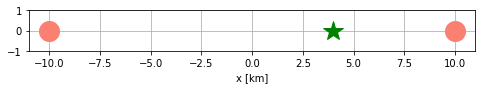

In [62]:
### create an ensemble of sources
dx=20. *1.e3 # in meters
sources=[]
sources.append(source(-dx*.5, 0))
sources.append(source( dx*.5, 0))
Ns = len(sources)

### init a receiver
#r=receiver(0. *1.e3, 0. *1.e3, e_x=10.e3)
r=receiver(4. *1.e3, 0, e_x=10.e3)

### init mapping
pmap = xtmap(c_b=1500., e_c=10., e_min=1.e-3)  #e_min on time (Cramer-Rao)

### plot
plt.figure(figsize=(8,3))
ax=plt.subplot(111)
[s.plot() for s in sources]
r.plot()
plt.ylim([-1, 1])
ax.grid()
ax.set_aspect('equal')
plt.xlabel('x [km]')
plt.show()

In [63]:
for i, s in enumerate(sources):
    print('Distance source %d - float = %.2f km' %(i, dist(s,r)/1.e3))
    print('    - Horizontal offset for a sound celerity difference of %.1f m/s = %.2f m' %(pmap.e_c, dist(s,r)*pmap.e_c/pmap.c_b))
    print('    - Corresponding propagation time uncertainty %.2e s \n' %(dist(s,r)*pmap.e_c/pmap.c_b**2))    

Distance source 0 - float = 14.00 km
    - Horizontal offset for a sound celerity difference of 10.0 m/s = 93.33 m
    - Corresponding propagation time uncertainty 6.22e-02 s 

Distance source 1 - float = 6.00 km
    - Horizontal offset for a sound celerity difference of 10.0 m/s = 40.00 m
    - Corresponding propagation time uncertainty 2.67e-02 s 



**- A priori uncertainties and estimates are :**

In [64]:
# a priori uncertainties : 
print("e_c  = %.1f m/s  (celerity)" %pmap.e_c)
# si e_c = 0 alors e_tp = e_min = 1.e-3 s

print("e_x  = %.1f m  (underwater float position)" %r.e_x)

e_c  = 10.0 m/s  (celerity)
e_x  = 10000.0 m  (underwater float position)


---
# 3 - Statistical simulations for 1 receiver position

For each source-receiver acoustic path, a random value of c is drawn around **c_b = 1500m/s**.
The standard deviation of the celerity is **e_c = 10 m/s**.

**- The true underwater float position and clock offset are:**

In [65]:
print('x = %.1f m \ndt = %.2e s' %(r.x, r.dt))

x = 4000.0 m 
dt = 2.57e-01 s


**- Unchanged variables during simulations are : **

In [66]:
print("s.x_t :", [s.x_t for s in sources])
#print("s.y_t :", [s.y_t for s in sources])
print("s.dx  :", [s.dx for s in sources])
#print("s.dy  :", [s.dy for s in sources])
#print("r.dt  :", r.dt)

s.x_t : [array([-10008.69608793]), array([9992.19261322])]
s.dx  : [array([-8.69608793]), array([-7.80738678])]


### 1 geolocalisation

In [76]:
r.t_r_tilda = np.array([s.t_e+pmap.draw_t(dist(s,r))+r.dt for s in sources]).squeeze()
x, dt, success, message, res = geolocalize_xtmap_1D(r, sources, pmap, clock_drift=False)

x_s :  [-10000.  10000.]
y_s :  [0 0]
t_e :  [0. 0.]
x0 : [0.]
W :  [1e-08, array([506.25, 506.25])]
x_sc :  [1000.]
new x0 :  [0.]


In [45]:
x    # donne la position de la source et non pas du récepteur ...

10000.281250000011

**- Simulations : only celerity between receiver and each source is changing** 

In [17]:
# simple geolocation 
Nmc = 1000
x=np.zeros(Nmc)
dt=np.zeros(Nmc)
su=np.zeros(Nmc)

for i in range(Nmc):
    r.t_r_tilda = np.array([s.t_e+pmap.draw_t(dist(s,r))+r.dt for s in sources]).squeeze()
    x[i], dt[i], success, message, res = geolocalize_xtmap_1D(r, sources, pmap, clock_drift=False)

d_rms = np.sqrt( np.mean( (x - r.x)**2 ))
bias_x = x.mean()-r.x
print('\nrms error, x bias : %.1fm, %.1fm' %(d_rms, bias_x))


rms error, x bias : 7500.0m, 7500.0m


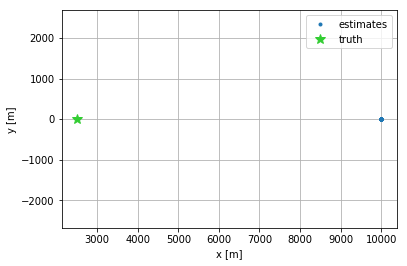

In [18]:
plt.figure()
ax=plt.subplot(111)
ax.plot(x,y,'.', label='estimates')
ax.plot(r.x,r.y,'*', color='limegreen', markersize=10, label='truth')
ax.axis('equal')
ax.grid()
ax.legend()
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
plt.show()

In [77]:
### rerun minimization with adjusted a priori estimates
Nmc = 1000
x=np.zeros(Nmc)
y=np.zeros(Nmc)
dt=np.zeros(Nmc)
su=np.zeros(Nmc)

for i in range(Nmc):
    # solve a first time
    r.t_r_tilda = np.array([s.t_e+pmap.draw_t(dist(s,r))+r.dt for s in sources]).squeeze()
    x[i], dt[i], success, message, res = geolocalize_xtmap_1D(r, sources, pmap, clock_drift=False)
    # rerun with adjusted expected errors on propagation time
    for j in range(1):
        x[i], dt[i], success, message, res = geolocalize_xtmap_1D(r, sources, pmap, clock_drift=False, \
                                                                     x0=[x[i], y[i], dt[i]])

d_rms = np.sqrt( np.mean( (x - r.x)**2  + (y - r.y)**2 ) )
bias_x = x.mean()-r.x
bias_y = y.mean()-r.y
print('\nrms error, x bias, y bias: %.1fm, %.1fm, %.1fm ' %(d_rms, bias_x, bias_y))

x_s :  [-10000.  10000.]
y_s :  [0 0]
t_e :  [0. 0.]
x0 : [0.]
W :  [1e-08, array([506.25, 506.25])]
x_sc :  [1000.]
new x0 :  [0.]
x_s :  [-10000.  10000.]
y_s :  [0 0]
t_e :  [0. 0.]
x0 : [10034.812500000011]
W :  [1e-08, array([1.26123052e+02, 1.00000000e+06])]
x_sc :  [1000.]
new x0 :  [10.0348125]
x_s :  [-10000.  10000.]
y_s :  [0 0]
t_e :  [0. 0.]
x0 : [0.]
W :  [1e-08, array([506.25, 506.25])]
x_sc :  [1000.]
new x0 :  [0.]
x_s :  [-10000.  10000.]
y_s :  [0 0]
t_e :  [0. 0.]
x0 : [10014.625000000013]
W :  [1e-08, array([1.26377605e+02, 1.00000000e+06])]
x_sc :  [1000.]
new x0 :  [10.014625]
x_s :  [-10000.  10000.]
y_s :  [0 0]
t_e :  [0. 0.]
x0 : [0.]
W :  [1e-08, array([506.25, 506.25])]
x_sc :  [1000.]
new x0 :  [0.]
x_s :  [-10000.  10000.]
y_s :  [0 0]
t_e :  [0. 0.]
x0 : [9946.187500000011]
W :  [1e-08, array([1.27246323e+02, 1.00000000e+06])]
x_sc :  [1000.]
new x0 :  [9.9461875]
x_s :  [-10000.  10000.]
y_s :  [0 0]
t_e :  [0. 0.]
x0 : [0.]
W :  [1e-08, array([506.25, 

x_sc :  [1000.]
new x0 :  [0.]
x_s :  [-10000.  10000.]
y_s :  [0 0]
t_e :  [0. 0.]
x0 : [10058.750000000011]
W :  [1e-08, array([1.25822209e+02, 1.00000000e+06])]
x_sc :  [1000.]
new x0 :  [10.05875]
x_s :  [-10000.  10000.]
y_s :  [0 0]
t_e :  [0. 0.]
x0 : [0.]
W :  [1e-08, array([506.25, 506.25])]
x_sc :  [1000.]
new x0 :  [0.]
x_s :  [-10000.  10000.]
y_s :  [0 0]
t_e :  [0. 0.]
x0 : [10039.625000000011]
W :  [1e-08, array([1.26062483e+02, 1.00000000e+06])]
x_sc :  [1000.]
new x0 :  [10.039625]
x_s :  [-10000.  10000.]
y_s :  [0 0]
t_e :  [0. 0.]
x0 : [0.]
W :  [1e-08, array([506.25, 506.25])]
x_sc :  [1000.]
new x0 :  [0.]
x_s :  [-10000.  10000.]
y_s :  [0 0]
t_e :  [0. 0.]
x0 : [9999.375000000011]
W :  [1e-08, array([1.26570411e+02, 1.00000000e+06])]
x_sc :  [1000.]
new x0 :  [9.999375]
x_s :  [-10000.  10000.]
y_s :  [0 0]
t_e :  [0. 0.]
x0 : [0.]
W :  [1e-08, array([506.25, 506.25])]
x_sc :  [1000.]
new x0 :  [0.]
x_s :  [-10000.  10000.]
y_s :  [0 0]
t_e :  [0. 0.]
x0 : [9997

W :  [1e-08, array([506.25, 506.25])]
x_sc :  [1000.]
new x0 :  [0.]
x_s :  [-10000.  10000.]
y_s :  [0 0]
t_e :  [0. 0.]
x0 : [9916.250000000013]
W :  [1e-08, array([1.27629156e+02, 1.00000000e+06])]
x_sc :  [1000.]
new x0 :  [9.91625]
x_s :  [-10000.  10000.]
y_s :  [0 0]
t_e :  [0. 0.]
x0 : [0.]
W :  [1e-08, array([506.25, 506.25])]
x_sc :  [1000.]
new x0 :  [0.]
x_s :  [-10000.  10000.]
y_s :  [0 0]
t_e :  [0. 0.]
x0 : [10014.562500000013]
W :  [1e-08, array([1.26378394e+02, 1.00000000e+06])]
x_sc :  [1000.]
new x0 :  [10.0145625]
x_s :  [-10000.  10000.]
y_s :  [0 0]
t_e :  [0. 0.]
x0 : [0.]
W :  [1e-08, array([506.25, 506.25])]
x_sc :  [1000.]
new x0 :  [0.]
x_s :  [-10000.  10000.]
y_s :  [0 0]
t_e :  [0. 0.]
x0 : [10018.187500000011]
W :  [1e-08, array([1.26332628e+02, 1.00000000e+06])]
x_sc :  [1000.]
new x0 :  [10.0181875]
x_s :  [-10000.  10000.]
y_s :  [0 0]
t_e :  [0. 0.]
x0 : [0.]
W :  [1e-08, array([506.25, 506.25])]
x_sc :  [1000.]
new x0 :  [0.]
x_s :  [-10000.  10000.

new x0 :  [9.8738125]
x_s :  [-10000.  10000.]
y_s :  [0 0]
t_e :  [0. 0.]
x0 : [0.]
W :  [1e-08, array([506.25, 506.25])]
x_sc :  [1000.]
new x0 :  [0.]
x_s :  [-10000.  10000.]
y_s :  [0 0]
t_e :  [0. 0.]
x0 : [9996.312500000011]
W :  [1e-08, array([1.26609183e+02, 1.00000000e+06])]
x_sc :  [1000.]
new x0 :  [9.9963125]
x_s :  [-10000.  10000.]
y_s :  [0 0]
t_e :  [0. 0.]
x0 : [0.]
W :  [1e-08, array([506.25, 506.25])]
x_sc :  [1000.]
new x0 :  [0.]
x_s :  [-10000.  10000.]
y_s :  [0 0]
t_e :  [0. 0.]
x0 : [9949.937500000011]
W :  [1e-08, array([1.2719849e+02, 1.0000000e+06])]
x_sc :  [1000.]
new x0 :  [9.9499375]
x_s :  [-10000.  10000.]
y_s :  [0 0]
t_e :  [0. 0.]
x0 : [0.]
W :  [1e-08, array([506.25, 506.25])]
x_sc :  [1000.]
new x0 :  [0.]
x_s :  [-10000.  10000.]
y_s :  [0 0]
t_e :  [0. 0.]
x0 : [9927.062500000011]
W :  [1e-08, array([1.2749069e+02, 1.0000000e+06])]
x_sc :  [1000.]
new x0 :  [9.9270625]
x_s :  [-10000.  10000.]
y_s :  [0 0]
t_e :  [0. 0.]
x0 : [0.]
W :  [1e-08, 

x_sc :  [1000.]
new x0 :  [0.]
x_s :  [-10000.  10000.]
y_s :  [0 0]
t_e :  [0. 0.]
x0 : [9967.625000000013]
W :  [1e-08, array([1.26973243e+02, 1.00000000e+06])]
x_sc :  [1000.]
new x0 :  [9.967625]
x_s :  [-10000.  10000.]
y_s :  [0 0]
t_e :  [0. 0.]
x0 : [0.]
W :  [1e-08, array([506.25, 506.25])]
x_sc :  [1000.]
new x0 :  [0.]
x_s :  [-10000.  10000.]
y_s :  [0 0]
t_e :  [0. 0.]
x0 : [9959.812500000011]
W :  [1e-08, array([1.2707266e+02, 1.0000000e+06])]
x_sc :  [1000.]
new x0 :  [9.9598125]
x_s :  [-10000.  10000.]
y_s :  [0 0]
t_e :  [0. 0.]
x0 : [0.]
W :  [1e-08, array([506.25, 506.25])]
x_sc :  [1000.]
new x0 :  [0.]
x_s :  [-10000.  10000.]
y_s :  [0 0]
t_e :  [0. 0.]
x0 : [10032.125000000011]
W :  [1e-08, array([1.26156895e+02, 1.00000000e+06])]
x_sc :  [1000.]
new x0 :  [10.032125]
x_s :  [-10000.  10000.]
y_s :  [0 0]
t_e :  [0. 0.]
x0 : [0.]
W :  [1e-08, array([506.25, 506.25])]
x_sc :  [1000.]
new x0 :  [0.]
x_s :  [-10000.  10000.]
y_s :  [0 0]
t_e :  [0. 0.]
x0 : [9920.3

new x0 :  [10.0838125]
x_s :  [-10000.  10000.]
y_s :  [0 0]
t_e :  [0. 0.]
x0 : [0.]
W :  [1e-08, array([506.25, 506.25])]
x_sc :  [1000.]
new x0 :  [0.]
x_s :  [-10000.  10000.]
y_s :  [0 0]
t_e :  [0. 0.]
x0 : [10046.125000000011]
W :  [1e-08, array([1.25980744e+02, 1.00000000e+06])]
x_sc :  [1000.]
new x0 :  [10.046125]
x_s :  [-10000.  10000.]
y_s :  [0 0]
t_e :  [0. 0.]
x0 : [0.]
W :  [1e-08, array([506.25, 506.25])]
x_sc :  [1000.]
new x0 :  [0.]
x_s :  [-10000.  10000.]
y_s :  [0 0]
t_e :  [0. 0.]
x0 : [10009.812500000011]
W :  [1e-08, array([1.26438402e+02, 1.00000000e+06])]
x_sc :  [1000.]
new x0 :  [10.0098125]
x_s :  [-10000.  10000.]
y_s :  [0 0]
t_e :  [0. 0.]
x0 : [0.]
W :  [1e-08, array([506.25, 506.25])]
x_sc :  [1000.]
new x0 :  [0.]
x_s :  [-10000.  10000.]
y_s :  [0 0]
t_e :  [0. 0.]
x0 : [9889.000000000011]
W :  [1e-08, array([1.27979126e+02, 1.00000000e+06])]
x_sc :  [1000.]
new x0 :  [9.889]
x_s :  [-10000.  10000.]
y_s :  [0 0]
t_e :  [0. 0.]
x0 : [0.]
W :  [1e-

x0 : [10059.125000000013]
W :  [1e-08, array([1.25817504e+02, 1.00000000e+06])]
x_sc :  [1000.]
new x0 :  [10.059125]
x_s :  [-10000.  10000.]
y_s :  [0 0]
t_e :  [0. 0.]
x0 : [0.]
W :  [1e-08, array([506.25, 506.25])]
x_sc :  [1000.]
new x0 :  [0.]
x_s :  [-10000.  10000.]
y_s :  [0 0]
t_e :  [0. 0.]
x0 : [9989.562500000011]
W :  [1e-08, array([1.26694703e+02, 1.00000000e+06])]
x_sc :  [1000.]
new x0 :  [9.9895625]
x_s :  [-10000.  10000.]
y_s :  [0 0]
t_e :  [0. 0.]
x0 : [0.]
W :  [1e-08, array([506.25, 506.25])]
x_sc :  [1000.]
new x0 :  [0.]
x_s :  [-10000.  10000.]
y_s :  [0 0]
t_e :  [0. 0.]
x0 : [10038.125000000011]
W :  [1e-08, array([1.26081357e+02, 1.00000000e+06])]
x_sc :  [1000.]
new x0 :  [10.038125]
x_s :  [-10000.  10000.]
y_s :  [0 0]
t_e :  [0. 0.]
x0 : [0.]
W :  [1e-08, array([506.25, 506.25])]
x_sc :  [1000.]
new x0 :  [0.]
x_s :  [-10000.  10000.]
y_s :  [0 0]
t_e :  [0. 0.]
x0 : [10077.812500000013]
W :  [1e-08, array([1.25583403e+02, 1.00000000e+06])]
x_sc :  [100

t_e :  [0. 0.]
x0 : [0.]
W :  [1e-08, array([506.25, 506.25])]
x_sc :  [1000.]
new x0 :  [0.]
x_s :  [-10000.  10000.]
y_s :  [0 0]
t_e :  [0. 0.]
x0 : [9985.875000000011]
W :  [1e-08, array([1.26741459e+02, 1.00000000e+06])]
x_sc :  [1000.]
new x0 :  [9.985875]
x_s :  [-10000.  10000.]
y_s :  [0 0]
t_e :  [0. 0.]
x0 : [0.]
W :  [1e-08, array([506.25, 506.25])]
x_sc :  [1000.]
new x0 :  [0.]
x_s :  [-10000.  10000.]
y_s :  [0 0]
t_e :  [0. 0.]
x0 : [9995.125000000013]
W :  [1e-08, array([1.26624222e+02, 1.00000000e+06])]
x_sc :  [1000.]
new x0 :  [9.995125]
x_s :  [-10000.  10000.]
y_s :  [0 0]
t_e :  [0. 0.]
x0 : [0.]
W :  [1e-08, array([506.25, 506.25])]
x_sc :  [1000.]
new x0 :  [0.]
x_s :  [-10000.  10000.]
y_s :  [0 0]
t_e :  [0. 0.]
x0 : [10121.375000000011]
W :  [1e-08, array([1.25040219e+02, 1.00000000e+06])]
x_sc :  [1000.]
new x0 :  [10.121375]
x_s :  [-10000.  10000.]
y_s :  [0 0]
t_e :  [0. 0.]
x0 : [0.]
W :  [1e-08, array([506.25, 506.25])]
x_sc :  [1000.]
new x0 :  [0.]
x

y_s :  [0 0]
t_e :  [0. 0.]
x0 : [10029.875000000011]
W :  [1e-08, array([1.2618524e+02, 1.0000000e+06])]
x_sc :  [1000.]
new x0 :  [10.029875]
x_s :  [-10000.  10000.]
y_s :  [0 0]
t_e :  [0. 0.]
x0 : [0.]
W :  [1e-08, array([506.25, 506.25])]
x_sc :  [1000.]
new x0 :  [0.]
x_s :  [-10000.  10000.]
y_s :  [0 0]
t_e :  [0. 0.]
x0 : [9932.12500000001]
W :  [1e-08, array([1.27425936e+02, 1.00000000e+06])]
x_sc :  [1000.]
new x0 :  [9.932125]
x_s :  [-10000.  10000.]
y_s :  [0 0]
t_e :  [0. 0.]
x0 : [0.]
W :  [1e-08, array([506.25, 506.25])]
x_sc :  [1000.]
new x0 :  [0.]
x_s :  [-10000.  10000.]
y_s :  [0 0]
t_e :  [0. 0.]
x0 : [9961.562500000013]
W :  [1e-08, array([1.27050381e+02, 1.00000000e+06])]
x_sc :  [1000.]
new x0 :  [9.9615625]
x_s :  [-10000.  10000.]
y_s :  [0 0]
t_e :  [0. 0.]
x0 : [0.]
W :  [1e-08, array([506.25, 506.25])]
x_sc :  [1000.]
new x0 :  [0.]
x_s :  [-10000.  10000.]
y_s :  [0 0]
t_e :  [0. 0.]
x0 : [9969.812500000013]
W :  [1e-08, array([1.26945427e+02, 1.000000

x_s :  [-10000.  10000.]
y_s :  [0 0]
t_e :  [0. 0.]
x0 : [0.]
W :  [1e-08, array([506.25, 506.25])]
x_sc :  [1000.]
new x0 :  [0.]
x_s :  [-10000.  10000.]
y_s :  [0 0]
t_e :  [0. 0.]
x0 : [10001.812500000013]
W :  [1e-08, array([1.26539564e+02, 1.00000000e+06])]
x_sc :  [1000.]
new x0 :  [10.0018125]
x_s :  [-10000.  10000.]
y_s :  [0 0]
t_e :  [0. 0.]
x0 : [0.]
W :  [1e-08, array([506.25, 506.25])]
x_sc :  [1000.]
new x0 :  [0.]
x_s :  [-10000.  10000.]
y_s :  [0 0]
t_e :  [0. 0.]
x0 : [9999.375000000011]
W :  [1e-08, array([1.26570411e+02, 1.00000000e+06])]
x_sc :  [1000.]
new x0 :  [9.999375]
x_s :  [-10000.  10000.]
y_s :  [0 0]
t_e :  [0. 0.]
x0 : [0.]
W :  [1e-08, array([506.25, 506.25])]
x_sc :  [1000.]
new x0 :  [0.]
x_s :  [-10000.  10000.]
y_s :  [0 0]
t_e :  [0. 0.]
x0 : [10060.875000000011]
W :  [1e-08, array([1.25795554e+02, 1.00000000e+06])]
x_sc :  [1000.]
new x0 :  [10.060875]
x_s :  [-10000.  10000.]
y_s :  [0 0]
t_e :  [0. 0.]
x0 : [0.]
W :  [1e-08, array([506.25, 5

W :  [1e-08, array([506.25, 506.25])]
x_sc :  [1000.]
new x0 :  [0.]
x_s :  [-10000.  10000.]
y_s :  [0 0]
t_e :  [0. 0.]
x0 : [9986.43750000001]
W :  [1e-08, array([1.26734325e+02, 1.00000000e+06])]
x_sc :  [1000.]
new x0 :  [9.9864375]
x_s :  [-10000.  10000.]
y_s :  [0 0]
t_e :  [0. 0.]
x0 : [0.]
W :  [1e-08, array([506.25, 506.25])]
x_sc :  [1000.]
new x0 :  [0.]
x_s :  [-10000.  10000.]
y_s :  [0 0]
t_e :  [0. 0.]
x0 : [9982.875000000011]
W :  [1e-08, array([1.26779517e+02, 1.00000000e+06])]
x_sc :  [1000.]
new x0 :  [9.982875]
x_s :  [-10000.  10000.]
y_s :  [0 0]
t_e :  [0. 0.]
x0 : [0.]
W :  [1e-08, array([506.25, 506.25])]
x_sc :  [1000.]
new x0 :  [0.]
x_s :  [-10000.  10000.]
y_s :  [0 0]
t_e :  [0. 0.]
x0 : [10030.250000000011]
W :  [1e-08, array([1.26180515e+02, 1.00000000e+06])]
x_sc :  [1000.]
new x0 :  [10.03025]
x_s :  [-10000.  10000.]
y_s :  [0 0]
t_e :  [0. 0.]
x0 : [0.]
W :  [1e-08, array([506.25, 506.25])]
x_sc :  [1000.]
new x0 :  [0.]
x_s :  [-10000.  10000.]
y_

x_sc :  [1000.]
new x0 :  [0.]
x_s :  [-10000.  10000.]
y_s :  [0 0]
t_e :  [0. 0.]
x0 : [10024.125000000013]
W :  [1e-08, array([1.2625772e+02, 1.0000000e+06])]
x_sc :  [1000.]
new x0 :  [10.024125]
x_s :  [-10000.  10000.]
y_s :  [0 0]
t_e :  [0. 0.]
x0 : [0.]
W :  [1e-08, array([506.25, 506.25])]
x_sc :  [1000.]
new x0 :  [0.]
x_s :  [-10000.  10000.]
y_s :  [0 0]
t_e :  [0. 0.]
x0 : [9963.500000000011]
W :  [1e-08, array([1.27025721e+02, 1.00000000e+06])]
x_sc :  [1000.]
new x0 :  [9.9635]
x_s :  [-10000.  10000.]
y_s :  [0 0]
t_e :  [0. 0.]
x0 : [0.]
W :  [1e-08, array([506.25, 506.25])]
x_sc :  [1000.]
new x0 :  [0.]
x_s :  [-10000.  10000.]
y_s :  [0 0]
t_e :  [0. 0.]
x0 : [9940.937500000011]
W :  [1e-08, array([1.27313334e+02, 1.00000000e+06])]
x_sc :  [1000.]
new x0 :  [9.9409375]
x_s :  [-10000.  10000.]
y_s :  [0 0]
t_e :  [0. 0.]
x0 : [0.]
W :  [1e-08, array([506.25, 506.25])]
x_sc :  [1000.]
new x0 :  [0.]
x_s :  [-10000.  10000.]
y_s :  [0 0]
t_e :  [0. 0.]
x0 : [10008.75

W :  [1e-08, array([506.25, 506.25])]
x_sc :  [1000.]
new x0 :  [0.]
x_s :  [-10000.  10000.]
y_s :  [0 0]
t_e :  [0. 0.]
x0 : [10005.437500000011]
W :  [1e-08, array([1.2649371e+02, 1.0000000e+06])]
x_sc :  [1000.]
new x0 :  [10.0054375]
x_s :  [-10000.  10000.]
y_s :  [0 0]
t_e :  [0. 0.]
x0 : [0.]
W :  [1e-08, array([506.25, 506.25])]
x_sc :  [1000.]
new x0 :  [0.]
x_s :  [-10000.  10000.]
y_s :  [0 0]
t_e :  [0. 0.]
x0 : [10005.937500000011]
W :  [1e-08, array([1.26487387e+02, 1.00000000e+06])]
x_sc :  [1000.]
new x0 :  [10.0059375]
x_s :  [-10000.  10000.]
y_s :  [0 0]
t_e :  [0. 0.]
x0 : [0.]
W :  [1e-08, array([506.25, 506.25])]
x_sc :  [1000.]
new x0 :  [0.]
x_s :  [-10000.  10000.]
y_s :  [0 0]
t_e :  [0. 0.]
x0 : [10036.687500000011]
W :  [1e-08, array([1.26099448e+02, 1.00000000e+06])]
x_sc :  [1000.]
new x0 :  [10.0366875]
x_s :  [-10000.  10000.]
y_s :  [0 0]
t_e :  [0. 0.]
x0 : [0.]
W :  [1e-08, array([506.25, 506.25])]
x_sc :  [1000.]
new x0 :  [0.]
x_s :  [-10000.  1000

y_s :  [0 0]
t_e :  [0. 0.]
x0 : [9948.125000000011]
W :  [1e-08, array([1.27221606e+02, 1.00000000e+06])]
x_sc :  [1000.]
new x0 :  [9.948125]
x_s :  [-10000.  10000.]
y_s :  [0 0]
t_e :  [0. 0.]
x0 : [0.]
W :  [1e-08, array([506.25, 506.25])]
x_sc :  [1000.]
new x0 :  [0.]
x_s :  [-10000.  10000.]
y_s :  [0 0]
t_e :  [0. 0.]
x0 : [10027.312500000011]
W :  [1e-08, array([1.26217533e+02, 1.00000000e+06])]
x_sc :  [1000.]
new x0 :  [10.0273125]
x_s :  [-10000.  10000.]
y_s :  [0 0]
t_e :  [0. 0.]
x0 : [0.]
W :  [1e-08, array([506.25, 506.25])]
x_sc :  [1000.]
new x0 :  [0.]
x_s :  [-10000.  10000.]
y_s :  [0 0]
t_e :  [0. 0.]
x0 : [9893.562500000011]
W :  [1e-08, array([1.2792043e+02, 1.0000000e+06])]
x_sc :  [1000.]
new x0 :  [9.8935625]
x_s :  [-10000.  10000.]
y_s :  [0 0]
t_e :  [0. 0.]
x0 : [0.]
W :  [1e-08, array([506.25, 506.25])]
x_sc :  [1000.]
new x0 :  [0.]
x_s :  [-10000.  10000.]
y_s :  [0 0]
t_e :  [0. 0.]
x0 : [10016.687500000011]
W :  [1e-08, array([1.26351563e+02, 1.000

y_s :  [0 0]
t_e :  [0. 0.]
x0 : [9981.062500000013]
W :  [1e-08, array([1.26802519e+02, 1.00000000e+06])]
x_sc :  [1000.]
new x0 :  [9.9810625]
x_s :  [-10000.  10000.]
y_s :  [0 0]
t_e :  [0. 0.]
x0 : [0.]
W :  [1e-08, array([506.25, 506.25])]
x_sc :  [1000.]
new x0 :  [0.]
x_s :  [-10000.  10000.]
y_s :  [0 0]
t_e :  [0. 0.]
x0 : [10081.312500000011]
W :  [1e-08, array([1.25539631e+02, 1.00000000e+06])]
x_sc :  [1000.]
new x0 :  [10.0813125]
x_s :  [-10000.  10000.]
y_s :  [0 0]
t_e :  [0. 0.]
x0 : [0.]
W :  [1e-08, array([506.25, 506.25])]
x_sc :  [1000.]
new x0 :  [0.]
x_s :  [-10000.  10000.]
y_s :  [0 0]
t_e :  [0. 0.]
x0 : [10032.812500000011]
W :  [1e-08, array([1.26148237e+02, 1.00000000e+06])]
x_sc :  [1000.]
new x0 :  [10.0328125]
x_s :  [-10000.  10000.]
y_s :  [0 0]
t_e :  [0. 0.]
x0 : [0.]
W :  [1e-08, array([506.25, 506.25])]
x_sc :  [1000.]
new x0 :  [0.]
x_s :  [-10000.  10000.]
y_s :  [0 0]
t_e :  [0. 0.]
x0 : [10098.187500000011]
W :  [1e-08, array([1.25328906e+02, 

new x0 :  [0.]
x_s :  [-10000.  10000.]
y_s :  [0 0]
t_e :  [0. 0.]
x0 : [10006.562500000011]
W :  [1e-08, array([1.26479484e+02, 1.00000000e+06])]
x_sc :  [1000.]
new x0 :  [10.0065625]
x_s :  [-10000.  10000.]
y_s :  [0 0]
t_e :  [0. 0.]
x0 : [0.]
W :  [1e-08, array([506.25, 506.25])]
x_sc :  [1000.]
new x0 :  [0.]
x_s :  [-10000.  10000.]
y_s :  [0 0]
t_e :  [0. 0.]
x0 : [10079.312500000013]
W :  [1e-08, array([1.25564641e+02, 1.00000000e+06])]
x_sc :  [1000.]
new x0 :  [10.0793125]
x_s :  [-10000.  10000.]
y_s :  [0 0]
t_e :  [0. 0.]
x0 : [0.]
W :  [1e-08, array([506.25, 506.25])]
x_sc :  [1000.]
new x0 :  [0.]
x_s :  [-10000.  10000.]
y_s :  [0 0]
t_e :  [0. 0.]
x0 : [10043.437500000013]
W :  [1e-08, array([1.2601453e+02, 1.0000000e+06])]
x_sc :  [1000.]
new x0 :  [10.0434375]
x_s :  [-10000.  10000.]
y_s :  [0 0]
t_e :  [0. 0.]
x0 : [0.]
W :  [1e-08, array([506.25, 506.25])]
x_sc :  [1000.]
new x0 :  [0.]
x_s :  [-10000.  10000.]
y_s :  [0 0]
t_e :  [0. 0.]
x0 : [10013.3125000000

x_s :  [-10000.  10000.]
y_s :  [0 0]
t_e :  [0. 0.]
x0 : [10015.375000000013]
W :  [1e-08, array([1.26368134e+02, 1.00000000e+06])]
x_sc :  [1000.]
new x0 :  [10.015375]
x_s :  [-10000.  10000.]
y_s :  [0 0]
t_e :  [0. 0.]
x0 : [0.]
W :  [1e-08, array([506.25, 506.25])]
x_sc :  [1000.]
new x0 :  [0.]
x_s :  [-10000.  10000.]
y_s :  [0 0]
t_e :  [0. 0.]
x0 : [10067.000000000011]
W :  [1e-08, array([1.25718773e+02, 1.00000000e+06])]
x_sc :  [1000.]
new x0 :  [10.067]
x_s :  [-10000.  10000.]
y_s :  [0 0]
t_e :  [0. 0.]
x0 : [0.]
W :  [1e-08, array([506.25, 506.25])]
x_sc :  [1000.]
new x0 :  [0.]
x_s :  [-10000.  10000.]
y_s :  [0 0]
t_e :  [0. 0.]
x0 : [10018.250000000011]
W :  [1e-08, array([1.26331839e+02, 1.00000000e+06])]
x_sc :  [1000.]
new x0 :  [10.01825]
x_s :  [-10000.  10000.]
y_s :  [0 0]
t_e :  [0. 0.]
x0 : [0.]
W :  [1e-08, array([506.25, 506.25])]
x_sc :  [1000.]
new x0 :  [0.]
x_s :  [-10000.  10000.]
y_s :  [0 0]
t_e :  [0. 0.]
x0 : [10051.562500000011]
W :  [1e-08, arr

x0 : [9872.062500000011]
W :  [1e-08, array([1.28197379e+02, 1.00000000e+06])]
x_sc :  [1000.]
new x0 :  [9.8720625]
x_s :  [-10000.  10000.]
y_s :  [0 0]
t_e :  [0. 0.]
x0 : [0.]
W :  [1e-08, array([506.25, 506.25])]
x_sc :  [1000.]
new x0 :  [0.]
x_s :  [-10000.  10000.]
y_s :  [0 0]
t_e :  [0. 0.]
x0 : [10017.750000000011]
W :  [1e-08, array([1.2633815e+02, 1.0000000e+06])]
x_sc :  [1000.]
new x0 :  [10.01775]
x_s :  [-10000.  10000.]
y_s :  [0 0]
t_e :  [0. 0.]
x0 : [0.]
W :  [1e-08, array([506.25, 506.25])]
x_sc :  [1000.]
new x0 :  [0.]
x_s :  [-10000.  10000.]
y_s :  [0 0]
t_e :  [0. 0.]
x0 : [9996.937500000011]
W :  [1e-08, array([1.26601269e+02, 1.00000000e+06])]
x_sc :  [1000.]
new x0 :  [9.9969375]
x_s :  [-10000.  10000.]
y_s :  [0 0]
t_e :  [0. 0.]
x0 : [0.]
W :  [1e-08, array([506.25, 506.25])]
x_sc :  [1000.]
new x0 :  [0.]
x_s :  [-10000.  10000.]
y_s :  [0 0]
t_e :  [0. 0.]
x0 : [9912.062500000011]
W :  [1e-08, array([1.27682843e+02, 1.00000000e+06])]
x_sc :  [1000.]
n

t_e :  [0. 0.]
x0 : [0.]
W :  [1e-08, array([506.25, 506.25])]
x_sc :  [1000.]
new x0 :  [0.]
x_s :  [-10000.  10000.]
y_s :  [0 0]
t_e :  [0. 0.]
x0 : [10002.187500000011]
W :  [1e-08, array([1.26534819e+02, 1.00000000e+06])]
x_sc :  [1000.]
new x0 :  [10.0021875]
x_s :  [-10000.  10000.]
y_s :  [0 0]
t_e :  [0. 0.]
x0 : [0.]
W :  [1e-08, array([506.25, 506.25])]
x_sc :  [1000.]
new x0 :  [0.]
x_s :  [-10000.  10000.]
y_s :  [0 0]
t_e :  [0. 0.]
x0 : [10083.812500000011]
W :  [1e-08, array([1.25508379e+02, 1.00000000e+06])]
x_sc :  [1000.]
new x0 :  [10.0838125]
x_s :  [-10000.  10000.]
y_s :  [0 0]
t_e :  [0. 0.]
x0 : [0.]
W :  [1e-08, array([506.25, 506.25])]
x_sc :  [1000.]
new x0 :  [0.]
x_s :  [-10000.  10000.]
y_s :  [0 0]
t_e :  [0. 0.]
x0 : [10060.562500000013]
W :  [1e-08, array([1.25799473e+02, 1.00000000e+06])]
x_sc :  [1000.]
new x0 :  [10.0605625]
x_s :  [-10000.  10000.]
y_s :  [0 0]
t_e :  [0. 0.]
x0 : [0.]
W :  [1e-08, array([506.25, 506.25])]
x_sc :  [1000.]
new x0 : 

W :  [1e-08, array([506.25, 506.25])]
x_sc :  [1000.]
new x0 :  [0.]
x_s :  [-10000.  10000.]
y_s :  [0 0]
t_e :  [0. 0.]
x0 : [10025.187500000011]
W :  [1e-08, array([1.26244322e+02, 1.00000000e+06])]
x_sc :  [1000.]
new x0 :  [10.0251875]
x_s :  [-10000.  10000.]
y_s :  [0 0]
t_e :  [0. 0.]
x0 : [0.]
W :  [1e-08, array([506.25, 506.25])]
x_sc :  [1000.]
new x0 :  [0.]
x_s :  [-10000.  10000.]
y_s :  [0 0]
t_e :  [0. 0.]
x0 : [10003.375000000013]
W :  [1e-08, array([1.26519796e+02, 1.00000000e+06])]
x_sc :  [1000.]
new x0 :  [10.003375]
x_s :  [-10000.  10000.]
y_s :  [0 0]
t_e :  [0. 0.]
x0 : [0.]
W :  [1e-08, array([506.25, 506.25])]
x_sc :  [1000.]
new x0 :  [0.]
x_s :  [-10000.  10000.]
y_s :  [0 0]
t_e :  [0. 0.]
x0 : [9961.250000000011]
W :  [1e-08, array([1.27054359e+02, 1.00000000e+06])]
x_sc :  [1000.]
new x0 :  [9.96125]
x_s :  [-10000.  10000.]
y_s :  [0 0]
t_e :  [0. 0.]
x0 : [0.]
W :  [1e-08, array([506.25, 506.25])]
x_sc :  [1000.]
new x0 :  [0.]
x_s :  [-10000.  10000.]

new x0 :  [0.]
x_s :  [-10000.  10000.]
y_s :  [0 0]
t_e :  [0. 0.]
x0 : [10006.687500000011]
W :  [1e-08, array([1.26477904e+02, 1.00000000e+06])]
x_sc :  [1000.]
new x0 :  [10.0066875]
x_s :  [-10000.  10000.]
y_s :  [0 0]
t_e :  [0. 0.]
x0 : [0.]
W :  [1e-08, array([506.25, 506.25])]
x_sc :  [1000.]
new x0 :  [0.]
x_s :  [-10000.  10000.]
y_s :  [0 0]
t_e :  [0. 0.]
x0 : [10043.562500000013]
W :  [1e-08, array([1.26012958e+02, 1.00000000e+06])]
x_sc :  [1000.]
new x0 :  [10.0435625]
x_s :  [-10000.  10000.]
y_s :  [0 0]
t_e :  [0. 0.]
x0 : [0.]
W :  [1e-08, array([506.25, 506.25])]
x_sc :  [1000.]
new x0 :  [0.]
x_s :  [-10000.  10000.]
y_s :  [0 0]
t_e :  [0. 0.]
x0 : [9944.875000000011]
W :  [1e-08, array([1.27263071e+02, 1.00000000e+06])]
x_sc :  [1000.]
new x0 :  [9.944875]
x_s :  [-10000.  10000.]
y_s :  [0 0]
t_e :  [0. 0.]
x0 : [0.]
W :  [1e-08, array([506.25, 506.25])]
x_sc :  [1000.]
new x0 :  [0.]
x_s :  [-10000.  10000.]
y_s :  [0 0]
t_e :  [0. 0.]
x0 : [10092.68750000001

y_s :  [0 0]
t_e :  [0. 0.]
x0 : [9963.750000000011]
W :  [1e-08, array([1.27022539e+02, 1.00000000e+06])]
x_sc :  [1000.]
new x0 :  [9.96375]
x_s :  [-10000.  10000.]
y_s :  [0 0]
t_e :  [0. 0.]
x0 : [0.]
W :  [1e-08, array([506.25, 506.25])]
x_sc :  [1000.]
new x0 :  [0.]
x_s :  [-10000.  10000.]
y_s :  [0 0]
t_e :  [0. 0.]
x0 : [9997.375000000013]
W :  [1e-08, array([1.26595729e+02, 1.00000000e+06])]
x_sc :  [1000.]
new x0 :  [9.997375]
x_s :  [-10000.  10000.]
y_s :  [0 0]
t_e :  [0. 0.]
x0 : [0.]
W :  [1e-08, array([506.25, 506.25])]
x_sc :  [1000.]
new x0 :  [0.]
x_s :  [-10000.  10000.]
y_s :  [0 0]
t_e :  [0. 0.]
x0 : [10000.187500000011]
W :  [1e-08, array([1.26560127e+02, 1.00000000e+06])]
x_sc :  [1000.]
new x0 :  [10.0001875]
x_s :  [-10000.  10000.]
y_s :  [0 0]
t_e :  [0. 0.]
x0 : [0.]
W :  [1e-08, array([506.25, 506.25])]
x_sc :  [1000.]
new x0 :  [0.]
x_s :  [-10000.  10000.]
y_s :  [0 0]
t_e :  [0. 0.]
x0 : [9917.000000000013]
W :  [1e-08, array([1.27619544e+02, 1.0000

W :  [1e-08, array([506.25, 506.25])]
x_sc :  [1000.]
new x0 :  [0.]
x_s :  [-10000.  10000.]
y_s :  [0 0]
t_e :  [0. 0.]
x0 : [9954.937500000011]
W :  [1e-08, array([1.27134756e+02, 1.00000000e+06])]
x_sc :  [1000.]
new x0 :  [9.9549375]
x_s :  [-10000.  10000.]
y_s :  [0 0]
t_e :  [0. 0.]
x0 : [0.]
W :  [1e-08, array([506.25, 506.25])]
x_sc :  [1000.]
new x0 :  [0.]
x_s :  [-10000.  10000.]
y_s :  [0 0]
t_e :  [0. 0.]
x0 : [9988.68750000001]
W :  [1e-08, array([1.26705795e+02, 1.00000000e+06])]
x_sc :  [1000.]
new x0 :  [9.9886875]
x_s :  [-10000.  10000.]
y_s :  [0 0]
t_e :  [0. 0.]
x0 : [0.]
W :  [1e-08, array([506.25, 506.25])]
x_sc :  [1000.]
new x0 :  [0.]
x_s :  [-10000.  10000.]
y_s :  [0 0]
t_e :  [0. 0.]
x0 : [9912.437500000011]
W :  [1e-08, array([1.27678033e+02, 1.00000000e+06])]
x_sc :  [1000.]
new x0 :  [9.9124375]
x_s :  [-10000.  10000.]
y_s :  [0 0]
t_e :  [0. 0.]
x0 : [0.]
W :  [1e-08, array([506.25, 506.25])]
x_sc :  [1000.]
new x0 :  [0.]
x_s :  [-10000.  10000.]
y

new x0 :  [10.0186875]
x_s :  [-10000.  10000.]
y_s :  [0 0]
t_e :  [0. 0.]
x0 : [0.]
W :  [1e-08, array([506.25, 506.25])]
x_sc :  [1000.]
new x0 :  [0.]
x_s :  [-10000.  10000.]
y_s :  [0 0]
t_e :  [0. 0.]
x0 : [10054.812500000011]
W :  [1e-08, array([1.25871621e+02, 1.00000000e+06])]
x_sc :  [1000.]
new x0 :  [10.0548125]
x_s :  [-10000.  10000.]
y_s :  [0 0]
t_e :  [0. 0.]
x0 : [0.]
W :  [1e-08, array([506.25, 506.25])]
x_sc :  [1000.]
new x0 :  [0.]
x_s :  [-10000.  10000.]
y_s :  [0 0]
t_e :  [0. 0.]
x0 : [9941.562500000013]
W :  [1e-08, array([1.27305354e+02, 1.00000000e+06])]
x_sc :  [1000.]
new x0 :  [9.9415625]
x_s :  [-10000.  10000.]
y_s :  [0 0]
t_e :  [0. 0.]
x0 : [0.]
W :  [1e-08, array([506.25, 506.25])]
x_sc :  [1000.]
new x0 :  [0.]
x_s :  [-10000.  10000.]
y_s :  [0 0]
t_e :  [0. 0.]
x0 : [10085.062500000011]
W :  [1e-08, array([1.25492757e+02, 1.00000000e+06])]
x_sc :  [1000.]
new x0 :  [10.0850625]
x_s :  [-10000.  10000.]
y_s :  [0 0]
t_e :  [0. 0.]
x0 : [0.]
W : 

t_e :  [0. 0.]
x0 : [10038.375000000013]
W :  [1e-08, array([1.26078211e+02, 1.00000000e+06])]
x_sc :  [1000.]
new x0 :  [10.038375]
x_s :  [-10000.  10000.]
y_s :  [0 0]
t_e :  [0. 0.]
x0 : [0.]
W :  [1e-08, array([506.25, 506.25])]
x_sc :  [1000.]
new x0 :  [0.]
x_s :  [-10000.  10000.]
y_s :  [0 0]
t_e :  [0. 0.]
x0 : [10045.750000000013]
W :  [1e-08, array([1.25985457e+02, 1.00000000e+06])]
x_sc :  [1000.]
new x0 :  [10.04575]
x_s :  [-10000.  10000.]
y_s :  [0 0]
t_e :  [0. 0.]
x0 : [0.]
W :  [1e-08, array([506.25, 506.25])]
x_sc :  [1000.]
new x0 :  [0.]
x_s :  [-10000.  10000.]
y_s :  [0 0]
t_e :  [0. 0.]
x0 : [10070.000000000011]
W :  [1e-08, array([1.25681192e+02, 1.00000000e+06])]
x_sc :  [1000.]
new x0 :  [10.07]
x_s :  [-10000.  10000.]
y_s :  [0 0]
t_e :  [0. 0.]
x0 : [0.]
W :  [1e-08, array([506.25, 506.25])]
x_sc :  [1000.]
new x0 :  [0.]
x_s :  [-10000.  10000.]
y_s :  [0 0]
t_e :  [0. 0.]
x0 : [9984.18750000001]
W :  [1e-08, array([1.26762865e+02, 1.00000000e+06])]
x_s

W :  [1e-08, array([506.25, 506.25])]
x_sc :  [1000.]
new x0 :  [0.]
x_s :  [-10000.  10000.]
y_s :  [0 0]
t_e :  [0. 0.]
x0 : [9980.312500000013]
W :  [1e-08, array([1.26812038e+02, 1.00000000e+06])]
x_sc :  [1000.]
new x0 :  [9.9803125]
x_s :  [-10000.  10000.]
y_s :  [0 0]
t_e :  [0. 0.]
x0 : [0.]
W :  [1e-08, array([506.25, 506.25])]
x_sc :  [1000.]
new x0 :  [0.]
x_s :  [-10000.  10000.]
y_s :  [0 0]
t_e :  [0. 0.]
x0 : [10055.187500000011]
W :  [1e-08, array([1.25866914e+02, 1.00000000e+06])]
x_sc :  [1000.]
new x0 :  [10.0551875]
x_s :  [-10000.  10000.]
y_s :  [0 0]
t_e :  [0. 0.]
x0 : [0.]
W :  [1e-08, array([506.25, 506.25])]
x_sc :  [1000.]
new x0 :  [0.]
x_s :  [-10000.  10000.]
y_s :  [0 0]
t_e :  [0. 0.]
x0 : [9980.375000000013]
W :  [1e-08, array([1.26811245e+02, 1.00000000e+06])]
x_sc :  [1000.]
new x0 :  [9.980375]
x_s :  [-10000.  10000.]
y_s :  [0 0]
t_e :  [0. 0.]
x0 : [0.]
W :  [1e-08, array([506.25, 506.25])]
x_sc :  [1000.]
new x0 :  [0.]
x_s :  [-10000.  10000.]

x_s :  [-10000.  10000.]
y_s :  [0 0]
t_e :  [0. 0.]
x0 : [0.]
W :  [1e-08, array([506.25, 506.25])]
x_sc :  [1000.]
new x0 :  [0.]
x_s :  [-10000.  10000.]
y_s :  [0 0]
t_e :  [0. 0.]
x0 : [9988.187500000011]
W :  [1e-08, array([1.26712135e+02, 1.00000000e+06])]
x_sc :  [1000.]
new x0 :  [9.9881875]
x_s :  [-10000.  10000.]
y_s :  [0 0]
t_e :  [0. 0.]
x0 : [0.]
W :  [1e-08, array([506.25, 506.25])]
x_sc :  [1000.]
new x0 :  [0.]
x_s :  [-10000.  10000.]
y_s :  [0 0]
t_e :  [0. 0.]
x0 : [9980.812500000011]
W :  [1e-08, array([1.26805692e+02, 1.00000000e+06])]
x_sc :  [1000.]
new x0 :  [9.9808125]
x_s :  [-10000.  10000.]
y_s :  [0 0]
t_e :  [0. 0.]
x0 : [0.]
W :  [1e-08, array([506.25, 506.25])]
x_sc :  [1000.]
new x0 :  [0.]
x_s :  [-10000.  10000.]
y_s :  [0 0]
t_e :  [0. 0.]
x0 : [10025.437500000011]
W :  [1e-08, array([1.2624117e+02, 1.0000000e+06])]
x_sc :  [1000.]
new x0 :  [10.0254375]
x_s :  [-10000.  10000.]
y_s :  [0 0]
t_e :  [0. 0.]
x0 : [0.]
W :  [1e-08, array([506.25, 506

t_e :  [0. 0.]
x0 : [9973.687500000011]
W :  [1e-08, array([1.26896176e+02, 1.00000000e+06])]
x_sc :  [1000.]
new x0 :  [9.9736875]
x_s :  [-10000.  10000.]
y_s :  [0 0]
t_e :  [0. 0.]
x0 : [0.]
W :  [1e-08, array([506.25, 506.25])]
x_sc :  [1000.]
new x0 :  [0.]
x_s :  [-10000.  10000.]
y_s :  [0 0]
t_e :  [0. 0.]
x0 : [10000.062500000011]
W :  [1e-08, array([1.26561709e+02, 1.00000000e+06])]
x_sc :  [1000.]
new x0 :  [10.0000625]
x_s :  [-10000.  10000.]
y_s :  [0 0]
t_e :  [0. 0.]
x0 : [0.]
W :  [1e-08, array([506.25, 506.25])]
x_sc :  [1000.]
new x0 :  [0.]
x_s :  [-10000.  10000.]
y_s :  [0 0]
t_e :  [0. 0.]
x0 : [10010.187500000011]
W :  [1e-08, array([1.26433663e+02, 1.00000000e+06])]
x_sc :  [1000.]
new x0 :  [10.0101875]
x_s :  [-10000.  10000.]
y_s :  [0 0]
t_e :  [0. 0.]
x0 : [0.]
W :  [1e-08, array([506.25, 506.25])]
x_sc :  [1000.]
new x0 :  [0.]
x_s :  [-10000.  10000.]
y_s :  [0 0]
t_e :  [0. 0.]
x0 : [10027.500000000011]
W :  [1e-08, array([1.2621517e+02, 1.0000000e+06]

x_sc :  [1000.]
new x0 :  [0.]
x_s :  [-10000.  10000.]
y_s :  [0 0]
t_e :  [0. 0.]
x0 : [10007.187500000011]
W :  [1e-08, array([1.26471582e+02, 1.00000000e+06])]
x_sc :  [1000.]
new x0 :  [10.0071875]
x_s :  [-10000.  10000.]
y_s :  [0 0]
t_e :  [0. 0.]
x0 : [0.]
W :  [1e-08, array([506.25, 506.25])]
x_sc :  [1000.]
new x0 :  [0.]
x_s :  [-10000.  10000.]
y_s :  [0 0]
t_e :  [0. 0.]
x0 : [9937.187500000011]
W :  [1e-08, array([1.27361232e+02, 1.00000000e+06])]
x_sc :  [1000.]
new x0 :  [9.9371875]
x_s :  [-10000.  10000.]
y_s :  [0 0]
t_e :  [0. 0.]
x0 : [0.]
W :  [1e-08, array([506.25, 506.25])]
x_sc :  [1000.]
new x0 :  [0.]
x_s :  [-10000.  10000.]
y_s :  [0 0]
t_e :  [0. 0.]
x0 : [10033.437500000011]
W :  [1e-08, array([1.26140366e+02, 1.00000000e+06])]
x_sc :  [1000.]
new x0 :  [10.0334375]
x_s :  [-10000.  10000.]
y_s :  [0 0]
t_e :  [0. 0.]
x0 : [0.]
W :  [1e-08, array([506.25, 506.25])]
x_sc :  [1000.]
new x0 :  [0.]
x_s :  [-10000.  10000.]
y_s :  [0 0]
t_e :  [0. 0.]
x0 : [

x_s :  [-10000.  10000.]
y_s :  [0 0]
t_e :  [0. 0.]
x0 : [0.]
W :  [1e-08, array([506.25, 506.25])]
x_sc :  [1000.]
new x0 :  [0.]
x_s :  [-10000.  10000.]
y_s :  [0 0]
t_e :  [0. 0.]
x0 : [9979.500000000013]
W :  [1e-08, array([1.26822353e+02, 1.00000000e+06])]
x_sc :  [1000.]
new x0 :  [9.9795]
x_s :  [-10000.  10000.]
y_s :  [0 0]
t_e :  [0. 0.]
x0 : [0.]
W :  [1e-08, array([506.25, 506.25])]
x_sc :  [1000.]
new x0 :  [0.]
x_s :  [-10000.  10000.]
y_s :  [0 0]
t_e :  [0. 0.]
x0 : [10047.562500000013]
W :  [1e-08, array([1.25962678e+02, 1.00000000e+06])]
x_sc :  [1000.]
new x0 :  [10.0475625]
x_s :  [-10000.  10000.]
y_s :  [0 0]
t_e :  [0. 0.]
x0 : [0.]
W :  [1e-08, array([506.25, 506.25])]
x_sc :  [1000.]
new x0 :  [0.]
x_s :  [-10000.  10000.]
y_s :  [0 0]
t_e :  [0. 0.]
x0 : [10003.062500000011]
W :  [1e-08, array([1.26523749e+02, 1.00000000e+06])]
x_sc :  [1000.]
new x0 :  [10.0030625]
x_s :  [-10000.  10000.]
y_s :  [0 0]
t_e :  [0. 0.]
x0 : [0.]
W :  [1e-08, array([506.25, 50

x0 : [9971.062500000011]
W :  [1e-08, array([1.26929537e+02, 1.00000000e+06])]
x_sc :  [1000.]
new x0 :  [9.9710625]
x_s :  [-10000.  10000.]
y_s :  [0 0]
t_e :  [0. 0.]
x0 : [0.]
W :  [1e-08, array([506.25, 506.25])]
x_sc :  [1000.]
new x0 :  [0.]
x_s :  [-10000.  10000.]
y_s :  [0 0]
t_e :  [0. 0.]
x0 : [10068.562500000011]
W :  [1e-08, array([1.25699198e+02, 1.00000000e+06])]
x_sc :  [1000.]
new x0 :  [10.0685625]
x_s :  [-10000.  10000.]
y_s :  [0 0]
t_e :  [0. 0.]
x0 : [0.]
W :  [1e-08, array([506.25, 506.25])]
x_sc :  [1000.]
new x0 :  [0.]
x_s :  [-10000.  10000.]
y_s :  [0 0]
t_e :  [0. 0.]
x0 : [9993.687500000011]
W :  [1e-08, array([1.2664243e+02, 1.0000000e+06])]
x_sc :  [1000.]
new x0 :  [9.9936875]
x_s :  [-10000.  10000.]
y_s :  [0 0]
t_e :  [0. 0.]
x0 : [0.]
W :  [1e-08, array([506.25, 506.25])]
x_sc :  [1000.]
new x0 :  [0.]
x_s :  [-10000.  10000.]
y_s :  [0 0]
t_e :  [0. 0.]
x0 : [9924.125000000011]
W :  [1e-08, array([1.27528285e+02, 1.00000000e+06])]
x_sc :  [1000.]

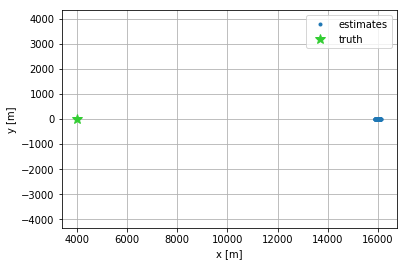

In [78]:
plt.figure()
ax=plt.subplot(111)
ax.plot(x,y,'.', label='estimates')
ax.plot(r.x,r.y,'*', color='limegreen', markersize=10, label='truth')
ax.axis('equal')
ax.grid()
ax.legend()
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
plt.show()

---
# 4 - Error map 

**- Function "simu" : simulations for one receiver position ; returns rms and bias.  **

In [22]:
def simu (r, sources, Nmc, var) : 
    x=np.zeros(Nmc)
    y=np.zeros(Nmc)
    dt=np.zeros(Nmc)
    su = np.zeros (Nmc)
    
    for i in range(Nmc):
        
        if var == 'celerity' : 
            [s.draw_celerity(s.e_c) for s in sources]
        if var == 'dxdy' : 
            [s.draw_dxdy(10.) for s in sources]
        if var == 'clock' : 
            r.draw_clock_drift()
            #dt_truth[i] = r.dt    
        
        # solve a first time
        r.t_r_tilda = np.array([s.t_e+pmap.draw_t(dist(s,r))+r.dt for s in sources]).squeeze()
        x[i], y[i], dt[i], success, message, res = geolocalize_xtmap(r, sources, pmap, clock_drift=False)
        # rerun with adjusted expected errors on propagation time
        for j in range(1):
            x[i], y[i], dt[i], success, message, res = geolocalize_xtmap(r, sources, pmap, \
                                                                         clock_drift=False, \
                                                                         x0=[x[i], y[i], dt[i]])
        if success :
            su[i] = 1 
        elif message.find('iterations')!= -1 : 
            # "Warning: Maximum number of iterations has been exceeded."
            su[i] = -1
        elif message.find('precision loss')!= -1 :
            #Warning: Desired error not necessarily achieved due to precision loss.
            su[i] = -2
        else : 
            su[i] = -3
    
    
    # rms error on the receiver position
    d_rms = np.sqrt( np.mean( (x[np.where(su==1)] - r.x)**2  + (y[np.where(su==1)] - r.y)**2 ) )
    # biais on the receiver position
    biais_x = x[np.where(su==1)].mean()-r.x
    biais_y = y[np.where(su==1)].mean()-r.y
    #biais = np.sqrt(biais_x**2 + biais_y**2)
    return (d_rms, bias_x, bias_y, su)

**- Creation of a grid : **

In [23]:
Lx = 20.* 1.e3
Ly = Lx 
xt = np.linspace(-Lx/2.,Lx/2.,20)   # 20 values on 20km : resolution of 1km 
yt = np.linspace(-Ly/2.,Ly/2.,20)
Xt, Yt = np.meshgrid(xt,yt)

**- Calculations for each receiver position :** 

In [24]:
### number of simulations 
Nmc = 100
var = 'celerity'

In [ ]:
### map calculations
RMS = np.zeros((len(xt),len(yt)))
Bias_x = np.zeros((len(xt),len(yt)))
Bias_y = np.zeros((len(xt),len(yt)))
Success = np.zeros((Nmc, len(xt),len(yt)))
dt = r.dt
for i in range (len(xt)) :
    print('i = %d/%d' %(i+1,len(xt)))
    for j in range (len(yt)):
        # init a receiver
        r = receiver(xt[i], yt[j])
        r.dt = dt # unchanged variable during simulations 
        
        # simulations 
        d_rms, bias_x, bias_y, su = simu (r, sources, Nmc, var = var) 
        RMS[i,j]        = d_rms
        Bias_x[i,j]     = bias_x
        Bias_y[i,j]     = bias_y
        Success[:,i,j]  = su

### saving        
np.save('RMS_20_20_nodrift', RMS)
np.save('BiasX_20_20_nodrift', Bias_x)
np.save('BiasY_20_20_nodrift', Bias_y)
np.save('Success_20_20_nodrift', Success)

In [28]:
RMS1 = np.load('NPY/RMS_20_20_nodrift.npy')
BiasX1 = np.load('NPY/BiasX_20_20_nodrift.npy')
BiasY1 = np.load('NPY/BiasY_20_20_nodrift.npy')
Success1 = np.load('NPY/Success_20_20_nodrift.npy')

In [29]:
Biais1 = np.sqrt(BiasX1**2 + BiasY1**2)

In [30]:
rej = np.where(Success1 != 1)[0].size
tot = Success1.size
print("%.1f" %(rej/tot*100.) + "% des minimisations ont échoué.")

0.0% des minimisations ont échoué.


**- Plots : error map + bias map**

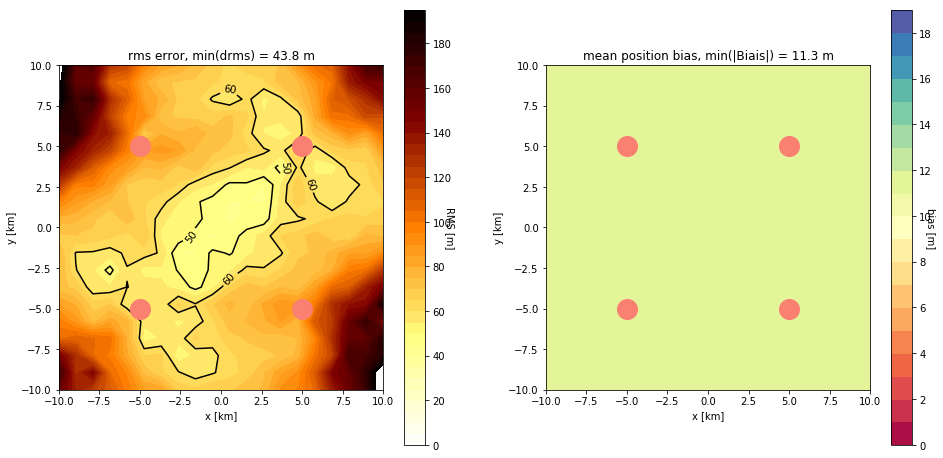

In [41]:
plt.figure(figsize=(16,8))

## error
ax=plt.subplot(121)
cmap = plt.get_cmap('afmhot_r')
lvls=np.arange(0.,2.e2,5.)
plt.contourf(Xt/1.e3,Yt/1.e3,RMS1,lvls, cmap=cmap)  #,lvls
cbar = plt.colorbar()
cbar.ax.set_ylabel('RMS [m]', rotation=270)

CS = plt.contour(Xt/1.e3,Yt/1.e3,RMS1,[50,60],colors='k')
plt.clabel(CS, [50,60],  # label every second level
           inline=1,
           fmt='%1.0f',
           fontsize=10)
[s.plot() for s in sources]
plt.xlabel('x [km]')
plt.ylabel('y [km]')
plt.title('rms error, min(drms) = %.1f m' % RMS1.min())
ax.set_aspect('equal')

## bias
ax=plt.subplot(122)
cmap = plt.get_cmap('Spectral')
lvls=np.arange(0.e1,2.e1,1.e0)
plt.contourf(Xt/1.e3,Yt/1.e3, Biais1,lvls,cmap=cmap)
cbar = plt.colorbar()
cbar.ax.set_ylabel('bias [m]', rotation=270)
[s.plot() for s in sources]
plt.xlabel('x [km]')
plt.ylabel('y [km]')
plt.title('mean position bias, min(|Biais|) = %.1f m' % np.abs(Biais1).min())
ax.set_aspect('equal')
plt.show()

---
# 5 - Transects

Calculations to create a map take a long time : it seems better to work with only one transect. 

**- Calculation and plot functions for transects : **

In [44]:
def transect (sources, X, Y, Nmc, var) :
    RMS_t = np.zeros((len(X)))
    BiasX_t = np.zeros((len(X)))
    BiasY_t = np.zeros((len(X)))
    Success_t = np.zeros((Nmc, len(X)))
    for i in range (len(X)) :
        # init a receiver
        r = receiver(X[i], Y)
        r.dt = 1. # unchanged variable during simulations 
        #
        d_rms, bias_x, bias_y, su = simu (r, sources, Nmc, var = var)

        RMS_t[i]       = d_rms
        BiasX_t[i]     = bias_x
        BiasY_t[i]     = bias_y
        Success_t[:,i] = su
    return RMS_t, BiasX_t, BiasY_t, Success_t


def plot_transect (sources, X, Y, RMS_t, Biais_t):
    print('min (rms) = %.1f m' %np.min(RMS_t))
    print('min (bias) = %.1f m' %np.min(Biais_t))
    plt.figure(figsize=(17,4))
    # plot sources 
    ax=plt.subplot(131)
    [s.plot() for s in sources]
    plt.title ('sources and transect')
    plt.xlabel('x [km]')
    plt.ylabel('y [km]')
    ax.grid()
    #ax.set_xlim([np.min(X)/1000.,np.max(X)/1000.])
    ax.set_ylim([-abs(sources[0].y_s)/1000. - 5., abs(sources[0].y_s)/1000. + 5.])
    ax.set_aspect('equal')
    plt.plot([np.min(X)/1000.,np.max(X)/1000.],[Y/1000.,Y/1000.],'.-b')

    ## plot rms result
    ax2 = plt.subplot(132)
    ax2.grid()
    plt.plot(X/1.e3, RMS_t, '.') 
    plt.xlabel('x [km]')
    plt.ylabel('RMS [m]')
    plt.title('RMS error along the transect Y=%.dkm' %int(Y/1000.))
    
    ## plot bias
    ax3  = plt.subplot(133)
    ax3.grid()
    plt.plot(X/1.e3, Biais_t, '.')
    plt.xlabel('x [km]')
    plt.ylabel('Bias [m]')
    plt.title('Bias along the transect Y=%.dkm' %int(Y/1000.))
    
    plt.show()

**- Creation of a transect : **

In [45]:
L = 40.* 1.e3
X = np.linspace(-L/2.,L/2.,200)  # resolution : 200m
Y = 0. 

**A - Distance between sources : 10km, with Y=0 km **

In [ ]:
Nmc = 100          # number of simulations
var = 'celerity'   # only celerity is varying
RMS_t, BiasX_t, BiasY_t, Success_t = transect (sources, X, Y, Nmc, var)

np.save('RMS_t_nodrift', RMS_t)
np.save('BiasX_t_nodrift', BiasX_t)
np.save('BiasY_t_nodrift', BiasY_t)
np.save('Success_t_nodrift', Success_t)

In [50]:
RMS_t     = np.load('NPY/RMS_t_nodrift.npy')
BiasX_t   = np.load('NPY/BiasX_t_nodrift.npy')
BiasY_t   = np.load('NPY/BiasY_t_nodrift.npy')
Success_t = np.load('NPY/Success_t_nodrift.npy')

min (rms) = 43.4 m
min (bias) = 11.3 m


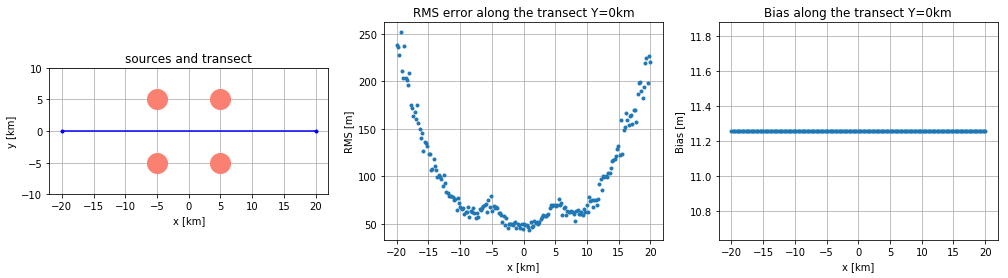

In [51]:
Biais_t = np.sqrt(BiasX_t**2 + BiasY_t**2)
plot_transect(sources, X, Y, RMS_t, Biais_t)

In [52]:
rej = np.where(Success_t != 1)[0].size
tot = Success_t.size
print("%.1f" %(rej/tot*100.) + "% des minimisations ont échoué.")

0.0% des minimisations ont échoué.


---
**B - Same distance, with Y=5 km **

In [53]:
Y = 5000.

In [ ]:
RMS_t5, BiasX_t5, BiasY_t5, Success_t5 = transect (sources, X, Y, Nmc, var)

np.save('RMS_t5_nodrift', RMS_t5)
np.save('BiasX_t5_nodrift', BiasX_t5)
np.save('BiasY_t5_nodrift', BiasY_t5)
np.save('Success_t5_nodrift', Success_t5)

In [56]:
RMS_t5     = np.load('NPY/RMS_t5_nodrift.npy')
BiasX_t5   = np.load('NPY/BiasX_t5_nodrift.npy')
BiasY_t5   = np.load('NPY/BiasY_t5_nodrift.npy')
Success_t5 = np.load('NPY/Success_t5_nodrift.npy')

min (rms) = 50.3 m
min (bias) = 11.3 m


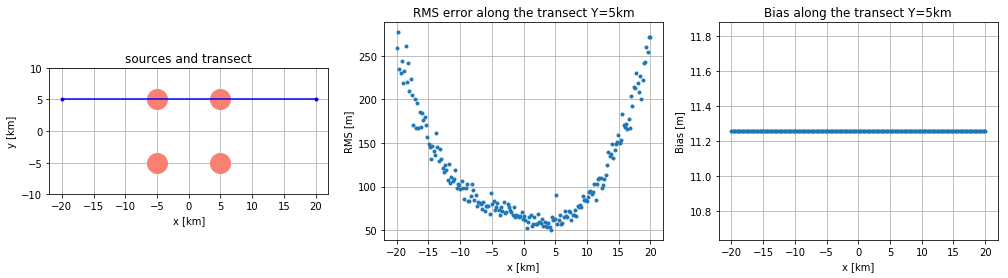

In [57]:
Biais_t5 = np.sqrt(BiasX_t5**2 + BiasY_t5**2)
plot_transect(sources, X, Y, RMS_t5, Biais_t5)

In [58]:
rej = np.where(Success_t5 != 1)[0].size
tot = Success_t5.size
print("%.1f" %(rej/tot*100.) + "% des minimisations ont échoué.")

0.0% des minimisations ont échoué.


---
**C - Distance between sources : 20km **

In [60]:
Y = 0.

In [61]:
dx=20. *1.e3 # in meters
sources=[]
sources.append(source(-dx*.5,-dx*.5))
sources.append(source(dx*.5,-dx*.5))
sources.append(source(dx*.5,dx*.5))
sources.append(source(-dx*.5,dx*.5))
Ns = len(sources)

In [ ]:
RMS_t20km, BiasX_t20km, BiasY_t20km, Success_t20km = transect (sources, X, Y, Nmc, var)

np.save('RMS_t20km_nodrift', RMS_t20km)
np.save('BiasX_t20km_nodrift', BiasX_t20km)
np.save('BiasY_t20km_nodrift', BiasY_t20km)
np.save('Success_t20km_nodrift', Success_t20km)

In [68]:
RMS_t20km     = np.load('NPY/RMS_t20km_nodrift.npy')
BiasX_t20km   = np.load('NPY/BiasX_t20km_nodrift.npy')
BiasY_t20km   = np.load('NPY/BiasY_t20km_nodrift.npy')
Success_t20km = np.load('NPY/Success_t20km_nodrift.npy')

In [69]:
rej = np.where(Success_t20km != 1)[0].size
tot = Success_t20km.size
print("%.2f" %(rej/tot*100.) + "% des minimisations ont échoué.")

0.01% des minimisations ont échoué.


min (rms) = 85.0 m
min (bias) = 11.3 m


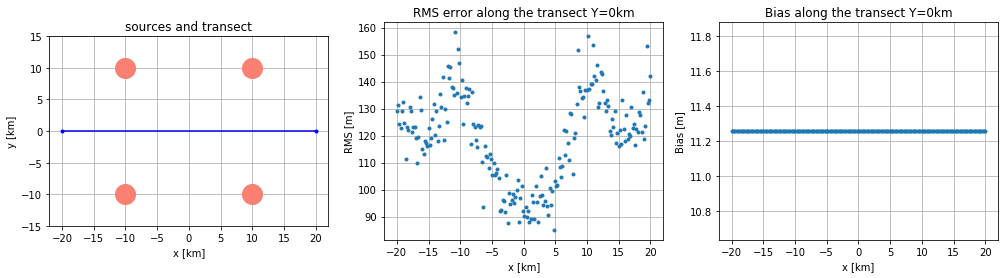

In [70]:
Biais_t20km = np.sqrt(BiasX_t20km**2 + BiasY_t20km**2)
plot_transect(sources, X, Y, RMS_t20km, Biais_t20km)

---
**D - With 5 sources (one on the center) **

In [71]:
# 5th source added
sources.append(source(0.,0.))
Ns = len(sources)

In [ ]:
RMS_t20_5sources, BiasX_t20_5sources, BiasY_t20_5sources, Success_t20_5sources = transect (sources, X, Y, Nmc, var)

np.save('RMS_t20km_5s_nodrift', RMS_t20_5sources)
np.save('BiasX_t20km_5s_nodrift', BiasX_t20_5sources)
np.save('BiasY_t20km_5s_nodrift', BiasY_t20_5sources)
np.save('Success_t20km_5s_nodrift', Success_t20_5sources)

In [73]:
RMS_t20_5sources     = np.load('NPY/RMS_t20km_5s_nodrift.npy')
BiasX_t20_5sources   = np.load('NPY/BiasX_t20km_5s_nodrift.npy')
BiasY_t20_5sources   = np.load('NPY/BiasY_t20km_5s_nodrift.npy')
Success_t20_5sources = np.load('NPY/Success_t20km_5s_nodrift.npy')

In [76]:
rej = np.where(Success_t20_5sources != 1)[0].size
tot = Success_t20_5sources.size
print("%.1f" %(rej/tot*100.) + "% des minimisations ont échoué.")

0.0% des minimisations ont échoué.


min (rms) = 55.9 m
min (bias) = 11.3 m


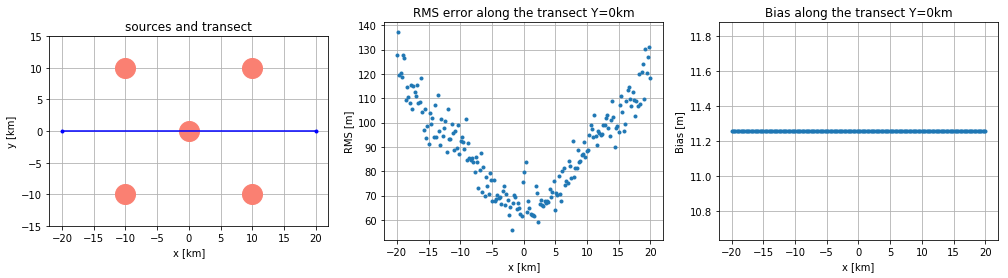

In [77]:
Biais_t20_5sources = np.sqrt(BiasX_t20_5sources**2 + BiasY_t20_5sources**2)
plot_transect(sources, X, Y, RMS_t20_5sources, Biais_t20_5sources)

---
**E - Y = 5km - 5 sources**

In [79]:
Y=5000.

In [ ]:
RMS_y5_5sources, BiasX_y5_5sources, BiasY_y5_5sources, Success_y5_5sources = transect (sources, X, Y, Nmc, var)

np.save('RMS_y5_5sources', RMS_y5_5sources)
np.save('BiasX_y5_5sources', BiasX_y5_5sources)
np.save('BiasY_y5_5sources', BiasY_y5_5sources)
np.save('Success_y5_5sources', Success_y5_5sources)

In [83]:
RMS_y5_5sources     = np.load('NPY/RMS_y5_5sources_nodrift.npy')
BiasX_y5_5sources   = np.load('NPY/BiasX_y5_5sources_nodrift.npy')
BiasY_y5_5sources   = np.load('NPY/BiasY_y5_5sources_nodrift.npy')
Success_y5_5sources = np.load('NPY/Success_y5_5sources_nodrift.npy')

In [86]:
rej = np.where(Success_y5_5sources != 1)[0].size
tot = Success_y5_5sources.size
print("%.1f" %(rej/tot*100.) + "% des minimisations ont échoué.")

0.0% des minimisations ont échoué.


min (rms) = 61.0 m
min (bias) = 11.3 m


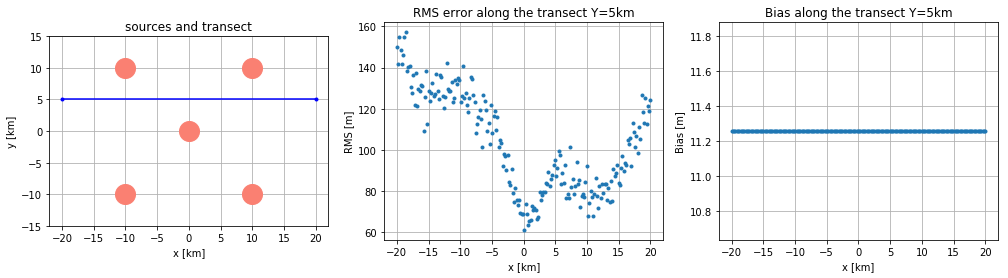

In [88]:
Biais_y5_5sources = np.sqrt(BiasX_y5_5sources**2 + BiasY_y5_5sources**2)
plot_transect(sources, X, Y, RMS_y5_5sources, Biais_y5_5sources)

In [ ]:
### tableau des minimums de RMS et biais suivant les config ??